In [27]:
#Global library
import pandas as pd
import numpy as np
import xgboost as xgb

#Plot library
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (8, 5.28) 
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["axes.titlesize"] = 13
plt.rcParams["axes.titleweight"] = 600

sns.set_color_codes("pastel")

#Preprocessing dataset library
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

from sklearn.preprocessing import OneHotEncoder
onehotencoder = OneHotEncoder()

#Algorithm library
from sklearn.neighbors import KNeighborsClassifier #KNN
from sklearn.naive_bayes import GaussianNB #NB
from sklearn.tree import DecisionTreeClassifier #DT
from sklearn.ensemble import RandomForestClassifier #RF
from sklearn.svm import SVC #SVM
from sklearn.neural_network import MLPClassifier #ANN
from sklearn.linear_model import LogisticRegression #LR

#Testing library
from sklearn import metrics

In [28]:
#Processing dataset UNSWNB15 - Load all dataset

#Load CSV - The dataset is contain training and testing data
df_train_unswnb15 = pd.read_csv('/Users/auliawardan/python/anomaly-detection/preprocessing/UNSW-NB15/train/UNSW_NB15_training-set.csv')
df_test_unswnb15 = pd.read_csv('/Users/auliawardan/python/anomaly-detection/preprocessing/UNSW-NB15/train/UNSW_NB15_testing-set.csv')

#We will look distribution of traffic and number of column in dataset
print("Training traffic size is {} rows and {} columns".format(df_train_unswnb15.shape[0],df_train_unswnb15.shape[1]))
print("Testing traffic size is {} rows and {} columns".format(df_test_unswnb15.shape[0],df_test_unswnb15.shape[1]))

Training traffic size is 82332 rows and 45 columns
Testing traffic size is 175341 rows and 45 columns


In [29]:
#Processing dataset UNSWNB15 - Print dataset for training info.

#Print info
df_train_unswnb15.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 82332 non-null  int64  
 1   dur                82332 non-null  float64
 2   proto              82332 non-null  object 
 3   service            82332 non-null  object 
 4   state              82332 non-null  object 
 5   spkts              82332 non-null  int64  
 6   dpkts              82332 non-null  int64  
 7   sbytes             82332 non-null  int64  
 8   dbytes             82332 non-null  int64  
 9   rate               82332 non-null  float64
 10  sttl               82332 non-null  int64  
 11  dttl               82332 non-null  int64  
 12  sload              82332 non-null  float64
 13  dload              82332 non-null  float64
 14  sloss              82332 non-null  int64  
 15  dloss              82332 non-null  int64  
 16  sinpkt             823

In [30]:
#Processing dataset UNSWNB15 - Print dataset for testing info.

#Print info
df_test_unswnb15.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175341 entries, 0 to 175340
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 175341 non-null  int64  
 1   dur                175341 non-null  float64
 2   proto              175341 non-null  object 
 3   service            175341 non-null  object 
 4   state              175341 non-null  object 
 5   spkts              175341 non-null  int64  
 6   dpkts              175341 non-null  int64  
 7   sbytes             175341 non-null  int64  
 8   dbytes             175341 non-null  int64  
 9   rate               175341 non-null  float64
 10  sttl               175341 non-null  int64  
 11  dttl               175341 non-null  int64  
 12  sload              175341 non-null  float64
 13  dload              175341 non-null  float64
 14  sloss              175341 non-null  int64  
 15  dloss              175341 non-null  int64  
 16  si

In [31]:
#Processing dataset UNSWNB15 (training) - Temporarily add new column to distinguish traffic type between Normal / Attack in training data
trf_type = df_train_unswnb15.loc[:, "label"].map(lambda lbl: "Normal" if lbl == 0 else "Abnormal")
trf_type.name = "traffic type"
df_train_unswnb15.loc[:, trf_type.name] = trf_type

#Check if resulting DataFrame valid
print("Total data {} rows and {} columns".format(df_train_unswnb15.shape[0],df_train_unswnb15.shape[1])) 

Total data 82332 rows and 46 columns


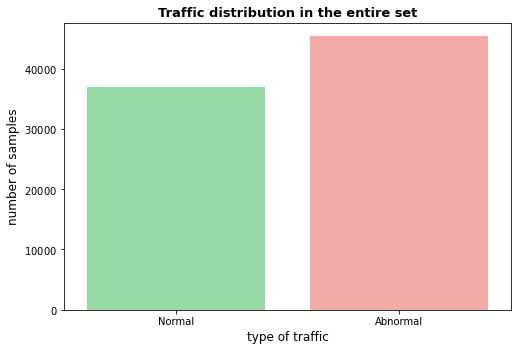

In [32]:
#Processing dataset UNSWNB15 (training) - Plot distrtibution of Normal traffic and Abnormal traffic in the whole dataset 

plt.ticklabel_format(axis='y', useMathText=True, useOffset=False)
sns.countplot(x="traffic type", data=df_train_unswnb15, palette=["g","r"])
plt.title("Traffic distribution in the entire set")
plt.xlabel("type of traffic")
plt.ylabel("number of samples")
plt.show()

In [33]:
#Processing dataset UNSWNB15 (testing) - Temporarily add new column to distinguish traffic type between Normal / Attack in training data
trf_type = df_test_unswnb15.loc[:, "label"].map(lambda lbl: "Normal" if lbl == 0 else "Abnormal")
trf_type.name = "traffic type"
df_test_unswnb15.loc[:, trf_type.name] = trf_type

#Check if resulting DataFrame valid
print("Total data {} rows and {} columns".format(df_test_unswnb15.shape[0],df_test_unswnb15.shape[1])) 

Total data 175341 rows and 46 columns


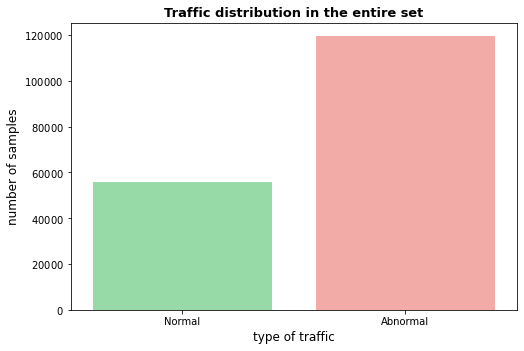

In [34]:
#Processing dataset UNSWNB15 (testing) - Plot distrtibution of Normal traffic and Abnormal traffic in the whole dataset 

plt.ticklabel_format(axis='y', useMathText=True, useOffset=False)
sns.countplot(x="traffic type", data=df_test_unswnb15, palette=["g","r"])
plt.title("Traffic distribution in the entire set")
plt.xlabel("type of traffic")
plt.ylabel("number of samples")
plt.show()

In [35]:
cols = df_train_unswnb15.select_dtypes(include=['float64','int64']).columns
sc_train_unswnb15 = scaler.fit_transform(df_train_unswnb15.select_dtypes(include=['float64','int64']))
sc_test_unswnb15 = scaler.fit_transform(df_test_unswnb15.select_dtypes(include=['float64','int64']))

sc_traindf_unswnb15 = pd.DataFrame(sc_train_unswnb15, columns = cols)
sc_testdf_unswnb15 = pd.DataFrame(sc_test_unswnb15, columns = cols)

trainDep_unswnb15 = df_train_unswnb15['traffic type'].values.reshape(-1,1)
trainDep_unswnb15 = onehotencoder.fit_transform(trainDep_unswnb15).toarray()
testDep_unswnb15 = df_test_unswnb15['traffic type'].values.reshape(-1,1)
testDep_unswnb15 = onehotencoder.fit_transform(testDep_unswnb15).toarray()

train_X_unswnb15 = sc_traindf_unswnb15
train_y_unswnb15 = trainDep_unswnb15[:,0]

test_X_unswnb15 = sc_testdf_unswnb15
test_y_unswnb15 = testDep_unswnb15[:,0]

In [36]:
#Training and testing phase

# Train K-Nearest Neighbors Model
KNN_Classifier = KNeighborsClassifier(n_jobs=-1)
KNN_Classifier.fit(train_X_unswnb15, train_y_unswnb15); 

models = []
models.append(('K-Nearest Neighbors Classifier', KNN_Classifier))

for i, v in models:
    accuracy = metrics.accuracy_score(test_y_unswnb15, v.predict(test_X_unswnb15))
    confusion_matrix = metrics.confusion_matrix(test_y_unswnb15, v.predict(test_X_unswnb15))
    classification = metrics.classification_report(test_y_unswnb15, v.predict(test_X_unswnb15))
    print()
    print('==================== {} Model Test Results ===================='.format(i))
    print()
    print ("Model Accuracy:" "\n", accuracy)
    print()
    print("Confusion matrix:" "\n", confusion_matrix)
    print()
    print("Classification report:" "\n", classification) 
    print()        


==================== K-Nearest Neighbors Classifier Model Test Results ====================

Model Accuracy:
 0.9889529545286042

Confusion matrix:
 [[ 55575    425]
 [  1512 117829]]

Classification report:
               precision    recall  f1-score   support

         0.0       0.97      0.99      0.98     56000
         1.0       1.00      0.99      0.99    119341

    accuracy                           0.99    175341
   macro avg       0.98      0.99      0.99    175341
weighted avg       0.99      0.99      0.99    175341




In [37]:
# Train Gaussian Naive Baye Model
NB_Classifier = GaussianNB()
NB_Classifier.fit(train_X_unswnb15, train_y_unswnb15)

models = []
models.append(('Naive Bayes Classifier', NB_Classifier))

for i, v in models:
    accuracy = metrics.accuracy_score(test_y_unswnb15, v.predict(test_X_unswnb15))
    confusion_matrix = metrics.confusion_matrix(test_y_unswnb15, v.predict(test_X_unswnb15))
    classification = metrics.classification_report(test_y_unswnb15, v.predict(test_X_unswnb15))
    print()
    print('==================== {} Model Test Results ===================='.format(i))
    print()
    print ("Model Accuracy:" "\n", accuracy)
    print()
    print("Confusion matrix:" "\n", confusion_matrix)
    print()
    print("Classification report:" "\n", classification) 
    print()


==================== Naive Bayes Classifier Model Test Results ====================

Model Accuracy:
 1.0

Confusion matrix:
 [[ 56000      0]
 [     0 119341]]

Classification report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56000
         1.0       1.00      1.00      1.00    119341

    accuracy                           1.00    175341
   macro avg       1.00      1.00      1.00    175341
weighted avg       1.00      1.00      1.00    175341




In [38]:
# Train Decision Tree Model
DT_Classifier = DecisionTreeClassifier(criterion='entropy', random_state=0)
DT_Classifier.fit(train_X_unswnb15, train_y_unswnb15)

models = []
models.append(('Decision Tree Classifier', DT_Classifier))

for i, v in models:
    accuracy = metrics.accuracy_score(test_y_unswnb15, v.predict(test_X_unswnb15))
    confusion_matrix = metrics.confusion_matrix(test_y_unswnb15, v.predict(test_X_unswnb15))
    classification = metrics.classification_report(test_y_unswnb15, v.predict(test_X_unswnb15))
    print()
    print('==================== {} Model Test Results ===================='.format(i))
    print()
    print ("Model Accuracy:" "\n", accuracy)
    print()
    print("Confusion matrix:" "\n", confusion_matrix)
    print()
    print("Classification report:" "\n", classification) 
    print()


==================== Decision Tree Classifier Model Test Results ====================

Model Accuracy:
 1.0

Confusion matrix:
 [[ 56000      0]
 [     0 119341]]

Classification report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56000
         1.0       1.00      1.00      1.00    119341

    accuracy                           1.00    175341
   macro avg       1.00      1.00      1.00    175341
weighted avg       1.00      1.00      1.00    175341




In [39]:
# Train Random Forest Model
RF_Classifier = RandomForestClassifier(max_depth=2, random_state=0)
RF_Classifier.fit(train_X_unswnb15, train_y_unswnb15)

models = []
models.append(('Random Forest Classifier', RF_Classifier))

for i, v in models:
    accuracy = metrics.accuracy_score(test_y_unswnb15, v.predict(test_X_unswnb15))
    confusion_matrix = metrics.confusion_matrix(test_y_unswnb15, v.predict(test_X_unswnb15))
    classification = metrics.classification_report(test_y_unswnb15, v.predict(test_X_unswnb15))
    print()
    print('==================== {} Model Test Results ===================='.format(i))
    print()
    print ("Model Accuracy:" "\n", accuracy)
    print()
    print("Confusion matrix:" "\n", confusion_matrix)
    print()
    print("Classification report:" "\n", classification) 
    print()


==================== Random Forest Classifier Model Test Results ====================

Model Accuracy:
 0.9867914520847948

Confusion matrix:
 [[ 53715   2285]
 [    31 119310]]

Classification report:
               precision    recall  f1-score   support

         0.0       1.00      0.96      0.98     56000
         1.0       0.98      1.00      0.99    119341

    accuracy                           0.99    175341
   macro avg       0.99      0.98      0.98    175341
weighted avg       0.99      0.99      0.99    175341


